In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [5]:
dataset = dconst.AMAZON_PHOTO

spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        # 'use_dataset_registry' : False,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
config_norm = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        # 'use_dataset_registry' : False,
    },
    **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    configuration.update_with_default_configuration(config_norm)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default all
INFO:root:Set configuration value data.corpus_labels to default all
INFO:root:Set configuration value data.train_labels to default all
INFO:root:Set configuration value data.left_out_class_labels to default ['Film Photography', 'Binoculars & Scopes', 'Video Surveillance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set 

True


In [6]:
config.data.setting

'hybrid'

In [7]:
if torch.cuda.is_available():
    config.training.gpus = 1
    config_norm.training.gpus = 1
    
config.training.gpus = 0
config_norm.training.gpus = 0
    

In [8]:
config.run.use_pretrained_model = True
config_norm.run.use_pretrained_model = True

In [9]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

INFO:root:Found precomputed dataset split at /nfs/students/fuchsgru/dataset_registry/3384787171.pt
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
model_seed = next(model_seed_generator)

In [11]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'continuous-distribution-shift')

In [12]:
class LoggingCallback(pl.callbacks.Callback):
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.global_step % 100 != 0:
            return
        
        l.info(' '.join(
            map(str, ['Epoch', trainer.global_step, 'acc', (pl_module(batch).get_predictions()[batch.mask].argmax(1) == batch.y[batch.mask]).float().mean().item()])
        
        ))
        

In [13]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=8, bias=False)
          )
      )
    )
  )
)


INFO:root:Loading pre-trained model from /nfs/students/fuchsgru/model_registry/2823847966.ckpt


In [14]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([0.7346491 , 0.7264491 , 0.7174763 , 0.7096519 , 0.7026238 ,
       0.69712776, 0.6890686 , 0.6815691 , 0.67004627, 0.6693591 ,
       0.66702974, 0.66070974, 0.6598726 , 0.65109503, 0.6466522 ,
       0.6394509 , 0.63842994, 0.63251376, 0.62698585, 0.6216435 ,
       0.61685723, 0.6143945 , 0.61349845, 0.6063887 , 0.59907514,
       0.5971    , 0.59223896, 0.58807075, 0.5852243 , 0.58092463,
       0.57603073, 0.57363534, 0.5695939 , 0.5644747 , 0.5599678 ,
       0.5511589 , 0.54899436, 0.5457873 , 0.54293305, 0.5389566 ,
       0.5353651 , 0.53249127, 0.5255816 , 0.5215531 , 0.5172963 ,
       0.5138978 , 0.51013654, 0.5025081 , 0.49835142, 0.49614796,
       0.4866263 , 0.48375157, 0.48183203, 0.477713  , 0.47427037,
       0.47326332, 0.4647028 , 0.4582284 , 0.44544435, 0.4398724 ,
       0.43543366, 0.43003064, 0.42726955, 0.41618708], dtype=float32)

In [15]:
config_norm.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_norm = make_model(config_norm, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_norm)
model_norm = train_model(model_norm, config_norm, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): ParametrizedLinear(
              in_features=745, out_features=64, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): SpectralNorm(rescaling=200.0, n_iter=1)
                )
              )
            )
          )
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithParametrization(
          (linear): ParametrizedLinear(
            in_features=745, out_features=64, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): SpectralNorm(rescaling=200.0, n_iter=1)
              )
            )
          )
        )
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Line

INFO:root:Loading pre-trained model from /nfs/students/fuchsgru/model_registry/3051766037.ckpt


In [16]:
model = model.cpu()
model_norm = model_norm.cpu()

In [17]:
# Check accuracy of both models
with torch.no_grad():
    data_val = data_dict[dconst.VAL][0]
    pred_val = model(data_val)
    pred_val_norm = model_norm(data_val)
    
    acc_val = (pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()
    acc_val_norm = (pred_val_norm.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

    print(acc_val, acc_val_norm)

tensor(0.1312) tensor(0.9438)


In [18]:
(pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

tensor(0.1312)

In [19]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([0.7346491 , 0.7264491 , 0.7174763 , 0.7096519 , 0.7026238 ,
       0.69712776, 0.6890686 , 0.6815691 , 0.67004627, 0.6693591 ,
       0.66702974, 0.66070974, 0.6598726 , 0.65109503, 0.6466522 ,
       0.6394509 , 0.63842994, 0.63251376, 0.62698585, 0.6216435 ,
       0.61685723, 0.6143945 , 0.61349845, 0.6063887 , 0.59907514,
       0.5971    , 0.59223896, 0.58807075, 0.5852243 , 0.58092463,
       0.57603073, 0.57363534, 0.5695939 , 0.5644747 , 0.5599678 ,
       0.5511589 , 0.54899436, 0.5457873 , 0.54293305, 0.5389566 ,
       0.5353651 , 0.53249127, 0.5255816 , 0.5215531 , 0.5172963 ,
       0.5138978 , 0.51013654, 0.5025081 , 0.49835142, 0.49614796,
       0.4866263 , 0.48375157, 0.48183203, 0.477713  , 0.47427037,
       0.47326332, 0.4647028 , 0.4582284 , 0.44544435, 0.4398724 ,
       0.43543366, 0.43003064, 0.42726955, 0.41618708], dtype=float32)

In [20]:
torch.allclose(pred_val.get_predictions() , pred_val_norm.get_predictions())

False

In [21]:
from data.transform import PerturbationTransform

In [22]:
data_train = data_dict[dconst.TRAIN][0]
data_val = data_dict[dconst.VAL][0]

In [23]:
with torch.no_grad():
    pred_train = model(data_train)
    pred_val = model(data_val)
    density_model = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=True,
    )
    density_model.fit(
        pred_train.get_features(-2)[data_train.mask], 
        pred_train.get_predictions()[data_train.mask], 
        pred_val.get_features(-2)[data_val.mask],
        pred_val.get_predictions()[data_val.mask],
    )

In [24]:
with torch.no_grad():
    pred_train_norm = model(data_train)
    pred_val_norm = model(data_val)
    density_model_norm = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=True,
    )
    density_model_norm.fit(
        pred_train_norm.get_features(-2)[data_train.mask], 
        pred_train_norm.get_predictions()[data_train.mask], 
        pred_val_norm.get_features(-2)[data_val.mask],
        pred_val_norm.get_predictions()[data_val.mask],
    )

In [25]:
model

SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=8, bias=False)
          )
      )
    )
  )
)

In [26]:
model.clear_and_disable_cache()
model_norm.clear_and_disable_cache()

INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [27]:
from copy import deepcopy

In [28]:
aurocs_density, aurocs_max_score = [], []
aurocs_density_no_edges, aurocs_max_score_no_edges = [], []
aurocs_density_norm, aurocs_max_score_norm = [], []
aurocs_density_norm_no_edges, aurocs_max_score_norm_no_edges = [], []
ps = []

resolution = 100
k = 10

for p in tqdm(np.linspace(0.0, 1.0, resolution)):
    for _ in range(k):
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        ps.append(p)
        with torch.no_grad():
            pred_p = model(deepcopy(data_p), remove_edges=False)
            pred_p_no_edges = model(deepcopy(data_p), remove_edges=True)
            pred_p_norm = model_norm(deepcopy(data_p), remove_edges=False)
            pred_p_norm_no_edges = model_norm(deepcopy(data_p), remove_edges=True)
            
            density_p = density_model(pred_p.get_features(-2))
            density_p_no_edges = density_model(pred_p_no_edges.get_features(-2))
            density_p_norm = density_model_norm(pred_p_norm.get_features(-2))
            density_p_norm_no_edges = density_model_norm(pred_p_norm_no_edges.get_features(-2))
            
            # Calculate AUROCs
            aurocs_density.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_no_edges.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_no_edges.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_norm.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_norm.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_norm.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_norm.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
            aurocs_density_norm_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p_norm_no_edges.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_norm_no_edges.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p_norm_no_edges.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))

100%|██████████| 100/100 [27:24<00:00, 16.45s/it]


In [29]:
from scipy.stats import binned_statistic

In [30]:
# Get uncertainty intervals for all sucess probabilities p
ps = np.array(ps).reshape((-1, k))
means, stds = {}, {}

for key, vals in {
    'aurocs_density' : aurocs_density, 'aurocs_max_score' : aurocs_max_score,
    'aurocs_density_no_edges' : aurocs_density_no_edges, 'aurocs_max_score_no_edges' : aurocs_max_score_no_edges,
    'aurocs_density_norm' : aurocs_density_norm, 'aurocs_max_score_norm' : aurocs_max_score_norm,
    'aurocs_density_norm_no_edges' : aurocs_density_norm_no_edges, 'aurocs_max_score_norm_no_edges' : aurocs_max_score_norm_no_edges,
}.items():
    vals = np.array(vals).reshape((resolution, k))
    means[key] = vals.mean(axis=1)
    stds[key] = vals.std(axis=1)
    
    


In [31]:



if dataset == dconst.CORA_FULL:
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[2, 0].set_ylabel('Count', fontsize=12)
    axs[1, 0].set_xlabel('Success Probability $p$', fontsize=12)
    axs[1, 1].set_xlabel('Success Probability $p$', fontsize=12)
    axs[2, 0].set_xlabel('Input Feature Density', fontsize=12)
    axs[2, 1].set_xlabel('Input Feature Density', fontsize=12)

    axs[0, 0].set_title('Vanilla GCN', fontsize=12)
    axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)
    axs[1, 0].set_title('Vanilla GCN, No Edges', fontsize=12)
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges', fontsize=12)
    axs[2, 0].set_title('Input Feature Distribution', fontsize=12)
    axs[2, 1].set_title('Input Feature Distribution', fontsize=12)

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', 
                        bbox_to_anchor=(1.13, 0.95), frameon=False, fontsize=12)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')

<ipython-input-32-4abd0be54fa3>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_yticklabels(['', '0.0', '1.0'])
<ipython-input-32-4abd0be54fa3>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_yticklabels(['', '0.0', '1.0'])


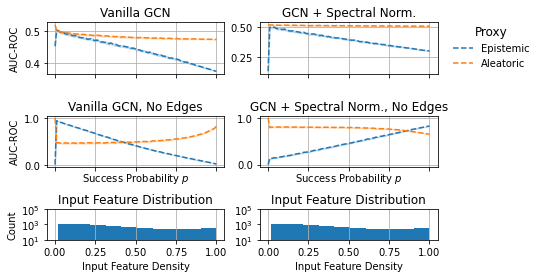

In [32]:

if dataset == dconst.AMAZON_PHOTO:


    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC')
    axs[1, 0].set_ylabel('AUC-ROC')
    axs[2, 0].set_ylabel('Count')
    axs[1, 0].set_xlabel('Success Probability $p$')
    axs[1, 1].set_xlabel('Success Probability $p$')
    axs[2, 0].set_xlabel('Input Feature Density')
    axs[2, 1].set_xlabel('Input Feature Density')

    axs[0, 0].set_title('Vanilla GCN')
    axs[0, 1].set_title('GCN + Spectral Norm.')
    axs[1, 0].set_title('Vanilla GCN, No Edges')
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges')
    axs[2, 0].set_title('Input Feature Distribution')
    axs[2, 1].set_title('Input Feature Distribution')

    axs[2, 0].set_yticks(axs[2, 0].get_yticks()[::2])
    axs[2, 1].set_yticks(axs[2, 1].get_yticks()[::2])
    axs[1, 0].set_yticklabels(['', '0.0', '1.0'])
    axs[1, 1].set_yticklabels(['', '0.0', '1.0'])

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', bbox_to_anchor=(1.1, 0.9), frameon=False)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')

In [33]:
if dataset == dconst.CITESEER:
    



    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 4), gridspec_kw = {
                           'height_ratios' : [1, 1, 0.6], 'wspace' : 0.2, 'hspace' : .95
    })

    def plot_proxy_at(key, ax, color, label):
        handle = ax.plot(ps[:, 0], means[key], color=color, label=label, linestyle='--')
        ax.fill_between(ps[:, 0], means[key] - stds[key], means[key] + stds[key], alpha = 0.2, color=color)
        return handle


    plot_proxy_at('aurocs_density', axs[0, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score', axs[0, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm', axs[0, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm', axs[0, 1], 'tab:orange', 'Aleatoric')

    plot_proxy_at('aurocs_density_no_edges', axs[1, 0], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_no_edges', axs[1, 0], 'tab:orange', 'Aleatoric')
    plot_proxy_at('aurocs_density_norm_no_edges', axs[1, 1], 'tab:blue', 'Epistemic')
    plot_proxy_at('aurocs_max_score_norm_no_edges', axs[1, 1], 'tab:orange', 'Aleatoric')

    handles = []
    handles += axs[-2, -1].plot([], [], color='tab:blue', label='Epistemic', linestyle='--')
    handles += axs[-2, -1].plot([], [], color='tab:orange', label='Aleatoric', linestyle='--')

    for ax in axs[:-1, :].flatten():
        ax.grid(which='major')
    for ax in axs[-1, :].flatten():
        ax.grid(which='major', axis='x')

    nnzs = (data_train.x.detach().cpu() > 0).float().mean(1).numpy()
    axs[2, 0].hist(nnzs, bins=10)
    axs[2, 0].set_yscale('log')
    axs[2, 1].hist(nnzs, bins=10)
    axs[2, 1].set_yscale('log')

    axs[0, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axs[2, 0].set_ylabel('Count', fontsize=12)
    axs[1, 0].set_xlabel('Success Probability $p$', fontsize=12)
    axs[1, 1].set_xlabel('Success Probability $p$', fontsize=12)
    axs[2, 0].set_xlabel('Input Feature Density', fontsize=12)
    axs[2, 1].set_xlabel('Input Feature Density', fontsize=12)

    axs[0, 0].set_title('Vanilla GCN', fontsize=12)
    axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=12)
    axs[1, 0].set_title('Vanilla GCN, No Edges', fontsize=12)
    axs[1, 1].set_title('GCN + Spectral Norm., No Edges', fontsize=12)
    axs[2, 0].set_title('Input Feature Distribution', fontsize=12)
    axs[2, 1].set_title('Input Feature Distribution', fontsize=12)
    
    axs[1, 0].set_yticklabels(['', '0.0', '1.0'])
    axs[1, 1].set_yticklabels(['', '0.0', '1.0'])

    legend = fig.legend(handles, ['Epistemic', 'Aleatoric'], title='Proxy', loc='upper right', 
                        bbox_to_anchor=(1.13, 0.95), 
               frameon=False, fontsize=12)
    plt.setp(legend.get_title(),fontsize=12)
    fig.savefig(f'thesis_nbs/continuous_distribution_shift_plots/{dataset}.pdf', bbox_inches='tight')